# Quara RNN Baseline

This kernel is based on:
1. Kernel ["LSTM is all you need! well, maybe embeddings also"](https://www.kaggle.com/mihaskalic/lstm-is-all-you-need-well-maybe-embeddings-also)
2. [Practical Text Classification With Python and Keras](https://mlwhiz.com/blog/2018/12/17/text_classification/)

The kernel is organised as follows:
1. Utils
2. Setup and Data Preprocessing
3. Neural Network
4. Prediction and Submission

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

seed = 123

## 1. Utils

#### 1.1 Dataset Loader

In [2]:
class DataLoader:
    
    def load(self, file_names):
        self.train_df = pd.read_csv(file_names['train'])
        self.test_df = pd.read_csv(file_names['test'])
        print("Train shape : ", self.train_df.shape)
        print("Test shape : ", self.test_df.shape)

#### 1.2 Load embeddings & transform text to vectors

In [3]:
class Embeddings:
    
    ## load embeddings
    def load(self, embedding_file_name):
        self.embeddings_index = {}
        f = open(embedding_file_name)
        for line in tqdm(f):
            values = line.split(' ');
            word = values[0]
            coef = np.asarray(values[1:], dtype='float32')
            self.embeddings_index[word] = coef
        self.embed_len = len(coef) # length of embeddings
        f.close()
        
    def text_to_vec(self, text, max_text_len=30):
        empyt_emb = np.zeros(self.embed_len)
        embeds = [self.embeddings_index.get(word, empyt_emb) for word in text]
        embeds+= [empyt_emb] * (max_text_len - len(embeds))
        
        return np.array(embeds)
    
    def sequences_to_vec(self, text_sequences, max_text_len=30):
        vectors = [self.text_to_vec(text[:max_text_len], max_text_len) for text in text_sequences]
        
        return np.array(vectors)

#### 1.3 Batch Generators

In [4]:
# generator for training NNet (used via fit_generator method in keras)
def batch_gen(train_df, batch_size, emb, random_state=None):
    import math
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1., random_state=random_state)  # Shuffle the data.
        for i in range(n_batches):
            batch_df = train_df.iloc[i*batch_size:(i+1)*batch_size]
            X_ = emb.sequences_to_vec( batch_df["question_text"])
            y_ = batch_df["target"].values
            yield X_, y_
            
# generater to do predication on test data
def batch_gen_test(test_df, emb, batch_size_test=512, random_state=None):
    import math
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        batch_df = test_df.iloc[i*batch_size:(i+1)*batch_size]
        X_ = emb.sequences_to_vec( batch_df["question_text"])
        yield X_

#### 1.4 Visualisation script (Learning curves)

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()

## 2. Setup and Data Preprocessing

#### 2.1 Load data

In [6]:
file_names = {'train': 'data/train.csv', 'test': 'data/test.csv'}

dl = DataLoader()
dl.load(file_names)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


#### 2.2  Load embeddings

In [7]:
embedding_file_name = 'data/embeddings/glove.840B.300d/glove.840B.300d.txt'
emb = Embeddings()
emb.load(embedding_file_name)
print('Embedding loaded')

2196017it [02:18, 15861.46it/s]

Embedding loaded


#### 2.3 Prepare train/validation sets

In [8]:
from sklearn.model_selection import train_test_split

val_size = 0.1
train_df, val_df, _, _ = train_test_split(dl.train_df, dl.train_df['target'], 
                                          test_size=val_size, 
                                          stratify=dl.train_df['target'],
                                          shuffle=True, random_state=seed)
val_X = emb.sequences_to_vec(val_df["question_text"])
val_y = val_df['target'].values

## 3. Neural Network

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 3.1 Define NNet

In [10]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),
                        input_shape=(30, 300)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 3.2 Train NNet

In [15]:
batch_size = 128
mg = batch_gen(train_df, batch_size, emb, random_state=seed)
model.fit_generator(mg, epochs=20,
                    steps_per_epoch=1000,
                    validation_data=(val_X, val_y),
                    verbose=True)

Epoch 1/20
1000/1000 [==============================] - 193s 193ms/step - loss: 0.1929 - acc: 0.9382 - val_loss: 0.1799 - val_acc: 0.9410
Epoch 2/20
1000/1000 [==============================] - 184s 184ms/step - loss: 0.1762 - acc: 0.9423 - val_loss: 0.1736 - val_acc: 0.9424
Epoch 3/20
1000/1000 [==============================] - 172s 172ms/step - loss: 0.1701 - acc: 0.9427 - val_loss: 0.1665 - val_acc: 0.9436
Epoch 4/20
1000/1000 [==============================] - 175s 175ms/step - loss: 0.1624 - acc: 0.9449 - val_loss: 0.1635 - val_acc: 0.9435
Epoch 5/20
1000/1000 [==============================] - 174s 174ms/step - loss: 0.1634 - acc: 0.9443 - val_loss: 0.1609 - val_acc: 0.9449
Epoch 6/20
1000/1000 [==============================] - 174s 174ms/step - loss: 0.1597 - acc: 0.9453 - val_loss: 0.1585 - val_acc: 0.9452
Epoch 7/20
1000/1000 [==============================] - 174s 174ms/step - loss: 0.1575 - acc: 0.9462 - val_loss: 0.1565 - val_acc: 0.9459
Epoch 8/20
1000/1000 [============

#### 3.3 Plot Learning curves

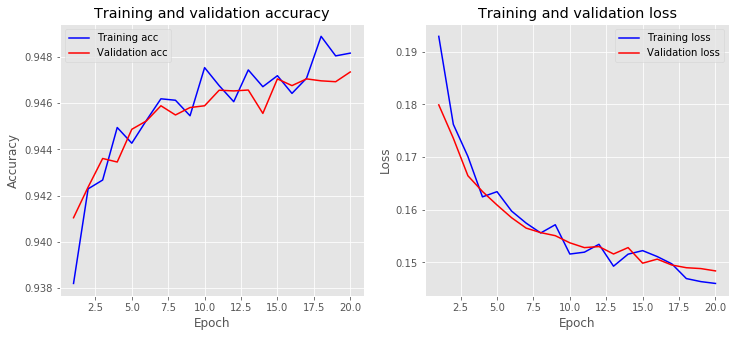

In [16]:
plot_history(model.history)

## 4. Prediction and Submission

#### 4. 1 Prediction

In [13]:
# predict probabilities
all_preds_prob = []
for x in tqdm(batch_gen_test(dl.test_df, emb)):
    all_preds_prob.extend(model.predict(x).flatten())
    
all_preds_prob_bin = (np.array(all_preds_prob) > 0.5).astype(np.int)

441it [00:29, 15.72it/s]


#### 4. 2 Submission

In [14]:
submit_df = pd.DataFrame({"qid": dl.test_df["qid"], "prediction": all_preds_prob_bin})
submit_df.to_csv("submission.csv", index=False)